## Setup

必要なライブラリをインポートして、初期化を行います。

Import the required libraries and initialize them:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import ros_numpy
import rospy
import tf
from gazebo_ros import gazebo_interface
from sensor_msgs.msg import LaserScan, PointCloud2
from geometry_msgs.msg import Pose, Quaternion ,TransformStamped,PoseStamped
import tf2_ros
import sys
from sklearn.decomposition import PCA
from utils import *
import cv2
import os
import math as m

from utils_takeshi import *
rgbd = RGBD()
scene = moveit_commander.PlanningSceneInterface()

In [2]:
%%script bash --bg
rviz -d data/task1.rviz > /dev/null 2>&1

Starting job # 0 in a separate thread.


In [3]:

rospy.init_node("recognition")


In [4]:

def seg_pca(lower=2000,higher=50000,reg_ly=0,reg_hy=1000): 
    image= rgbd.get_h_image()
    points_data= rgbd.get_points()
    values=image.reshape((-1,3))
    values= np.float32(values)
    criteria= (  cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER  ,1000,0.1)
    k=6
    _ , labels , cc =cv2.kmeans(values , k ,None,criteria,30,cv2.KMEANS_RANDOM_CENTERS)
    cc=np.uint8(cc)
    segmented_image= cc[labels.flatten()]
    segmented_image=segmented_image.reshape(image.shape)
    th3 = cv2.adaptiveThreshold(segmented_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    kernel = np.ones((5,5),np.uint8)
    im4=cv2.erode(th3,kernel,iterations=4)
    plane_mask=points_data['z']
    cv2_img=plane_mask.astype('uint8')
    img=im4
    _,contours, hierarchy = cv2.findContours(im4.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    points=[]
    for i, contour in enumerate(contours):
        
        area = cv2.contourArea(contour)

        if area > lower and area < higher :
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            
    
            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this

            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            # calculate moments for each contour
            if (cY > reg_ly and cY < reg_hy  ):
                
                cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                print ('cX,cY',cX,cY)
                xyz=[]


                for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                    for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                        aux=(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
                        if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                            'reject point'
                        else:
                            xyz.append(aux)

                xyz=np.asarray(xyz)
                cent=xyz.mean(axis=0)
                cents.append(cent)
                print (cent)
                points.append(xyz)
            else:
                print ('cent out of region... rejected')
            
    cents=np.asarray(cents)
    plt.imshow(im4)
    ### returns centroids found and a group of 3d coordinates that conform the centroid
    return(cents,np.asarray(points))



def static_tf_publish(cents, quaternions=[]):
    if (len(quaternions))==0:
        quats=np.zeros((len(cents),4)) 
        quats[:,3]=1
        print quats
    else:
        quats=np.asarray(quaternions)
        print quats
    for  i ,cent  in enumerate(cents):
        x,y,z=cent
        if np.isnan(x) or np.isnan(y) or np.isnan(z):
            print('nan')
        else:
            #### first place a dissolving tf wrt head sensor  in centroids
            broadcaster.sendTransform((x,y,z),rot, rospy.Time.now(), 'Closest_Object'+str(i),"head_rgbd_sensor_link")
            rospy.sleep(.2)
            
            #### then place each centr wrt map
            xyz_map,cent_quat= listener.lookupTransform('/map', 'Closest_Object'+str(i),rospy.Time(0))
            map_euler=tf.transformations.euler_from_quaternion(cent_quat)
            rospy.sleep(.2)
            static_transformStamped = TransformStamped()

            ##FIXING TF TO MAP ( ODOM REALLY)    
            #tf_broadcaster1.sendTransform( (xyz[0],xyz[1],xyz[2]),tf.transformations.quaternion_from_euler(0, 0, 0), rospy.Time.now(), "obj"+str(ind), "head_rgbd_sensor_link")
            ## Finally boiradcast a static tf  in cents and with quaternion found  in pca
            static_transformStamped.header.stamp = rospy.Time.now()
            static_transformStamped.header.frame_id = "map"
            static_transformStamped.child_frame_id = "static"+str(i)
            static_transformStamped.transform.translation.x = float(xyz_map[0])
            static_transformStamped.transform.translation.y = float(xyz_map[1])
            static_transformStamped.transform.translation.z = float(xyz_map[2])
            #quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
            static_transformStamped.transform.rotation.x = quats [i,0]#-quat[0]#trans.transform.rotation.x
            static_transformStamped.transform.rotation.y = quats [i,1]#-quat[1]#trans.transform.rotation.y
            static_transformStamped.transform.rotation.z = quats [i,2]#-quat[2]#trans.transform.rotation.z
            static_transformStamped.transform.rotation.w = quats [i,3]#-quat[3]#trans.transform.rotation.w


            tf_static_broadcaster.sendTransform(static_transformStamped)
    return True




In [5]:
def lineup_table():
    
    cv2_img=rgbd.get_image()
    img=cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
    img=cv2.Canny(img,80,200)
    lines = cv2.HoughLines(img,1,np.pi/180,150)
    first=True
    for line in lines:
        for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
            size=12
            if first:
                size=52
                first=False

            img=cv2.line(img,(x1,y1),(x2,y2),(255,255,255),size)

    #
    plt.imshow(img)
    wb=whole_body.get_current_joint_values()
    wb[2]+=-(lines[0,0,1]-.5*np.pi)
    succ=whole_body.go(wb)
    
    lines=np.asarray(lines)
    l=len(lines)
    lines=lines.ravel().reshape(l,2)
    table_limit_px=[]
    for line in lines :
        if (np.isclose(line[1], [1.57], atol=0.1)):
            table_limit_px.append(line[0])
    table_region=np.asarray([np.min(table_limit_px), np.max(table_limit_px)])
    print (table_region)
    
    return table_region 


In [6]:
listener = tf.TransformListener()
broadcaster= tf.TransformBroadcaster()
tf_static_broadcaster= tf2_ros.StaticTransformBroadcaster()
import moveit_commander
import moveit_msgs.msg
###might take some time to load all those takeshi meshes in rviz

head = moveit_commander.MoveGroupCommander('head')
arm = moveit_commander.MoveGroupCommander('arm')
whole_body = moveit_commander.MoveGroupCommander('whole_body_light')
whole_body.set_workspace([-10.0, -10.0, 10.0, 10.0])

In [7]:
from move_base_msgs.msg import MoveBaseAction, MoveBaseGoal
from geometry_msgs.msg import PoseStamped, Point , Quaternion
from actionlib_msgs.msg import GoalStatus

In [8]:
### TAKE ROBOT TO TABLE WITH OBJECTS ( IDEALLY 45degs)

In [28]:
arm.set_named_target('go')
arm.go()
head.set_named_target('neutral')
head.go()
goal_x , goal_y, goal_yaw = kl_table2
succ = move_base_goal(goal_x-.2, goal_y , goal_yaw+90)      

head.set_named_target('neutral')
head.go()

arm.set_joint_value_target(arm_grasp_table)
arm.go()

wb= whole_body.get_current_joint_values()
wb[3]+=.1
succ=whole_body.go(wb)

In [30]:
wb= whole_body.get_current_joint_values()
wb[3]-=.1
succ=whole_body.go(wb)

[104. 383.]


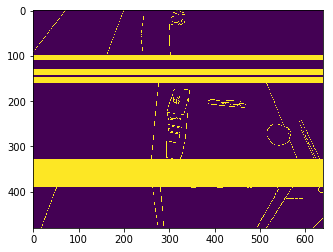

In [31]:

head_val=head.get_current_joint_values()
head_val[0]=np.deg2rad(-90)
head_val[1]=np.deg2rad(-45)
head.go(head_val)

table_region=lineup_table()



cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
('cX,cY', 547, 293)
[0.36502028 0.08262009 0.87559336]
('cX,cY', 439, 223)
[ 0.19191544 -0.02538642  0.8903339 ]
('cX,cY', 336, 266)
[0.02479844 0.03551645 0.7651732 ]
cent out of region... rejected


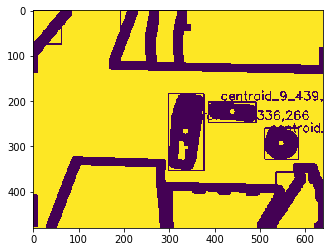

In [23]:
trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0))
cents, xyz = seg_pca(2000,20000,table_region[0],table_region[1])


In [24]:
quats=pca_xyz(xyz)


In [25]:
static_tf_publish(cents,quats)


[[ 0.05047095  0.50409711  0.13363341  0.85175167]
 [-0.020612    0.04585457 -0.91786274  0.39370102]
 [-0.68290412  0.143001   -0.70489015 -0.12775976]]


True

In [16]:
line[1]=0

NameError: name 'line' is not defined

In [ ]:

quats=pca_xyz(xyz)

#FIND PCA OF EACH OBJECT

In [ ]:
## CHECK RVIZ AND TFS

In [ ]:
from utils_takeshi import *